# Curating the dataset for Fine Tuning

In [ ]:
!pip install -q datasets transformers sentence_transformers faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset

dataset = load_dataset('garage-bAInd/Open-Platypus')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.34k [00:00<?, ?B/s]

(…)-00000-of-00001-4fe2df04669d1669.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24926 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [ ]:
from google.colab import userdata

hf_token = userdata.get('huggingface')

In [ ]:
dataset['train'].to_pandas()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K
...,...,...,...,...
24921,,There are several formulas that generate all p...,Can we find a formula to generate all prime nu...,guanaco
24922,,"Sure, here are some of the best universities:\...",What are some of the best university's for stu...,guanaco
24923,,[Enter stage left]\n\nFirst Citizen: Good morr...,Write me a SPL (Shakespeare Programming Langua...,guanaco
24924,,That's a very thoughtful idea! Here are some s...,Hi. I want to make an embossed picture for my ...,guanaco


###Convert the raw text to tokens and plotting the results

In [ ]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

tokenizer = AutoTokenizer.from_pretrained('NousResearch/Llama-2-7b-hf')
tokenizer

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

LlamaTokenizerFast(name_or_path='NousResearch/Llama-2-7b-hf', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

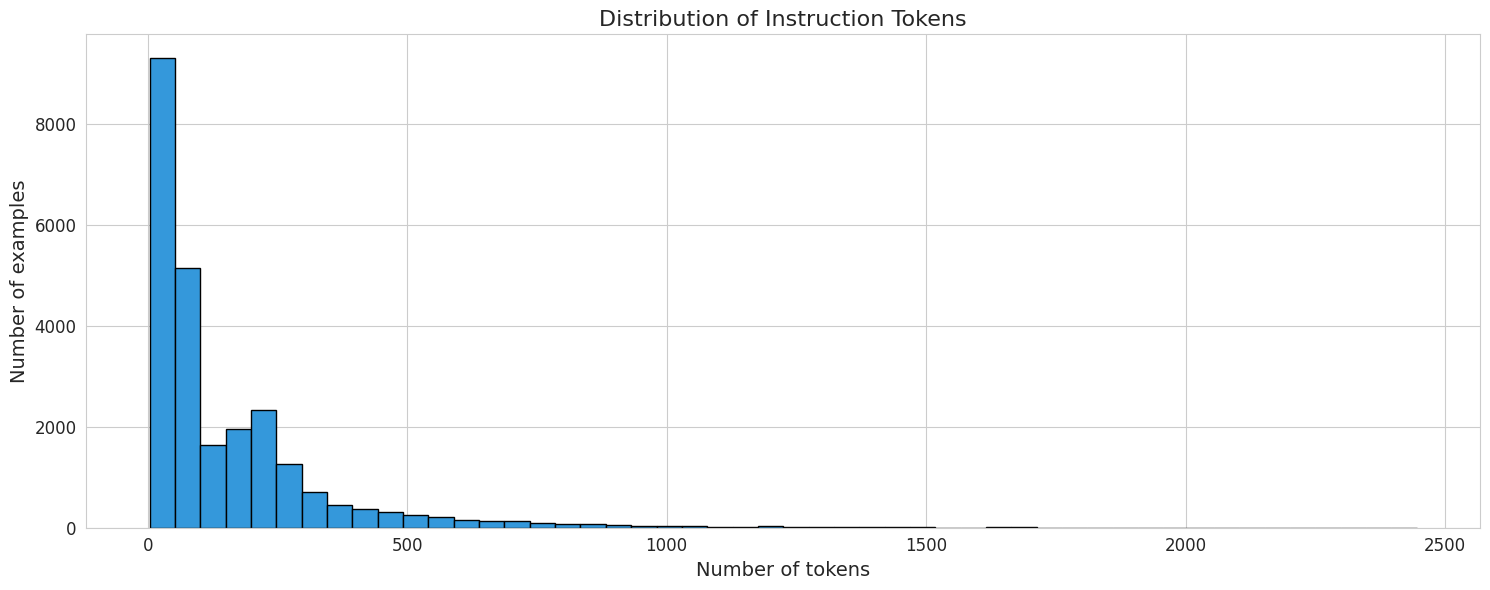

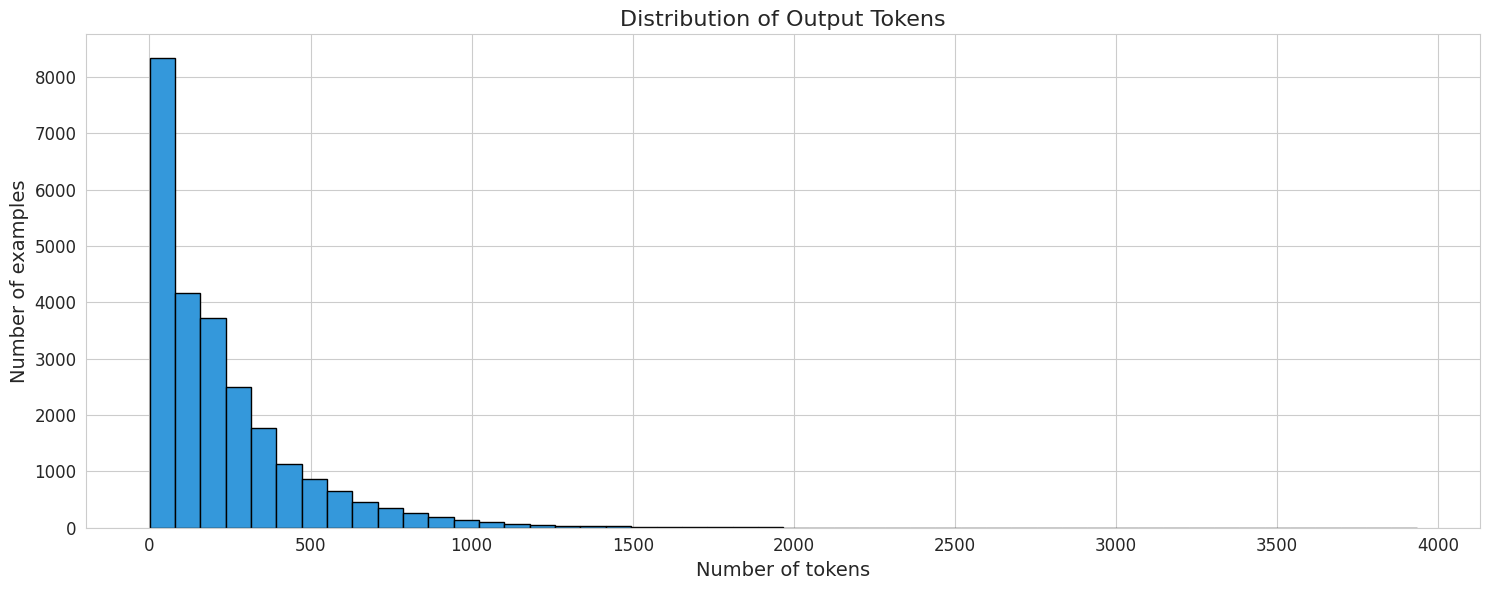

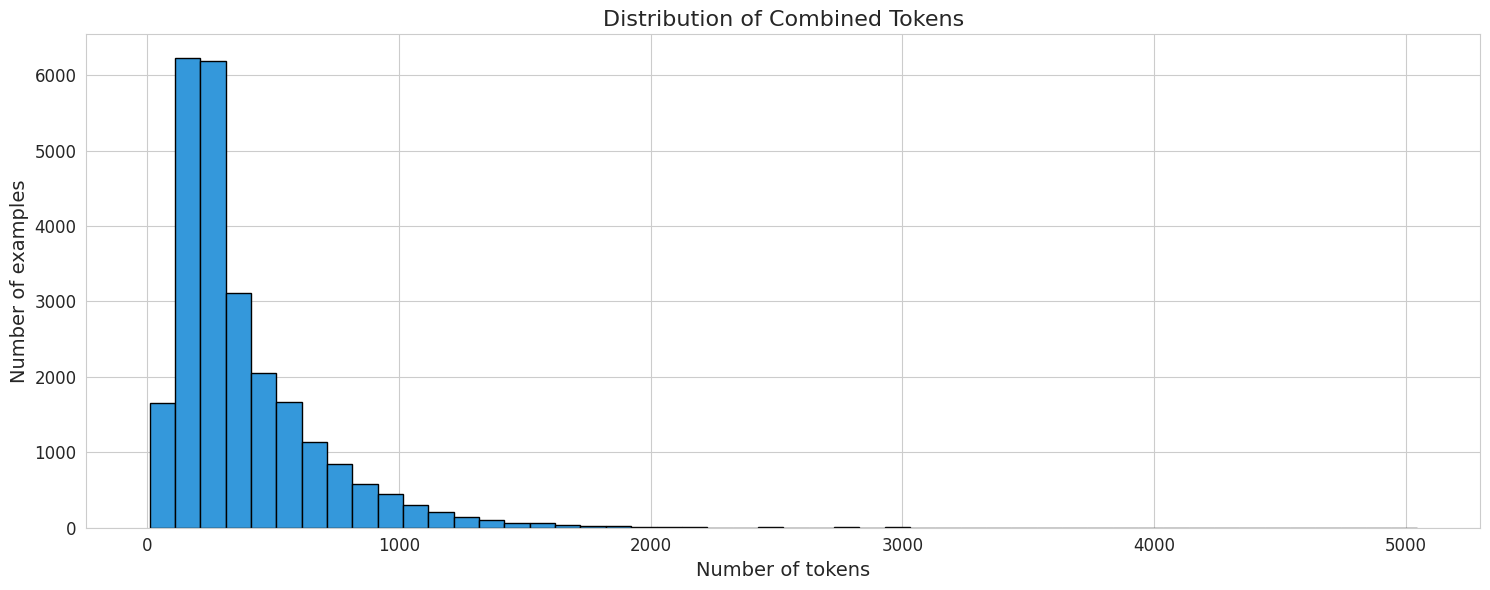

In [ ]:
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

def plot_distribution(token_counts, title):
  sns.set_style("whitegrid")
  plt.figure(figsize=(15,6))
  plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
  plt.title(title, fontsize=16)
  plt.xlabel("Number of tokens", fontsize=14)
  plt.ylabel("Number of examples", fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

plot_distribution(instruction_token_counts, "Distribution of Instruction Tokens")
plot_distribution(output_token_counts, "Distribution of Output Tokens")
plot_distribution(combined_token_counts, "Distribution of Combined Tokens")

## Filter out rows with more than 2048 tokens

We remove samples with more than 2048 tokens (max context size of Llama 2 by default is 4096)

In [ ]:
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <=2048]
print(len(valid_indices))

24895


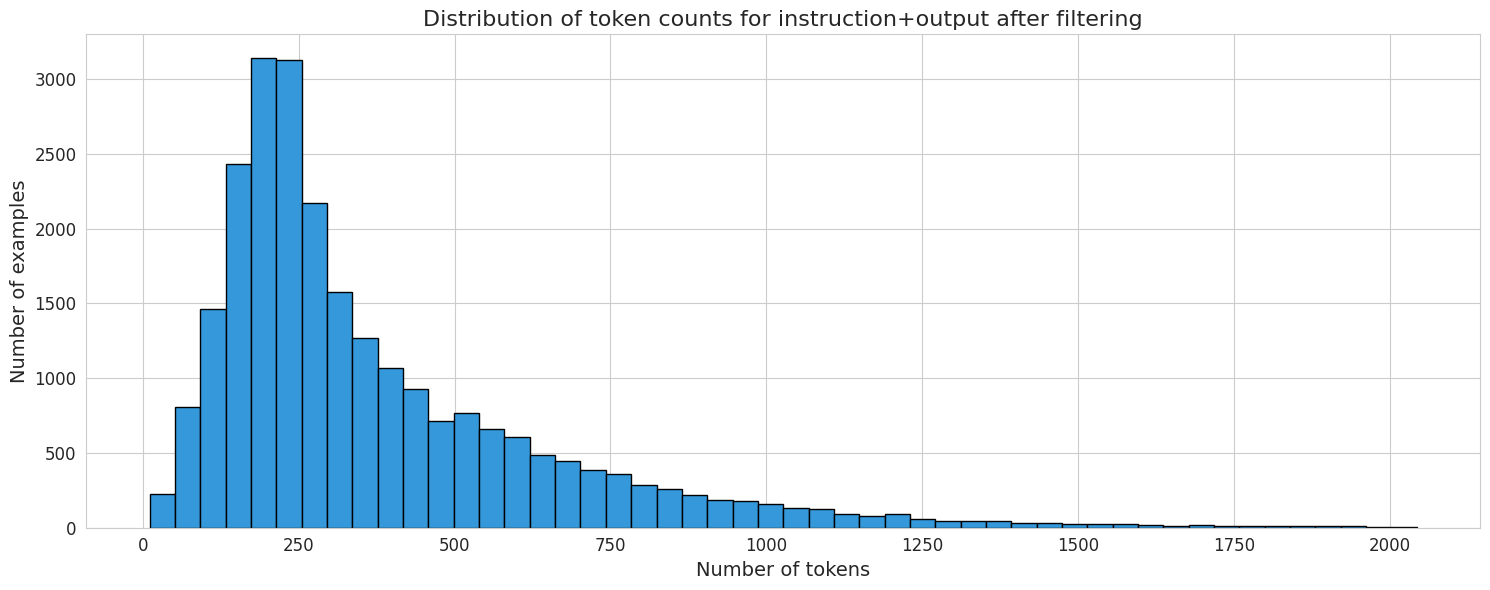

In [ ]:
dataset['train'] = dataset['train'].select(valid_indices)

token_counts = [combined_token_counts[i] for i in valid_indices]

plot_distribution(token_counts, "Distribution of token counts for instruction+output after filtering")

## Near-deduplication using embeddings

we can choose the embedding model using MTEB leadboard in huggingface

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

# filtering out similar outputs using embedding vectors
def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
  sentence_model = SentenceTransformer(model)
  outputs = [example["output"] for example in dataset['train']]

  print("Converting text to embeddings")
  embeddings = sentence_model.encode(outputs, show_progress_bar=True)
  dimension = embeddings.shape[1]
  index = faiss.IndexFlatIP(dimension)
  normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
  index.add(normalized_embeddings)

  print("Filtering out near-duplicates")
  D, I = index.search(normalized_embeddings, k=2)
  to_keep = []
  for i in tqdm(range(len(embeddings)), desc="Filtering"):
    if D[i, 1] < threshold:
      to_keep.append(i)
  dataset = dataset['train'].select(to_keep)
  return DatasetDict({'train': dataset})

# the threshold to similar distribution using another embedding model may be different
deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Converting text to embeddings


Batches:   0%|          | 0/778 [00:00<?, ?it/s]

Filtering out near-duplicates


Filtering:   0%|          | 0/24895 [00:00<?, ?it/s]

In [ ]:
print(len(dataset['train']))
print(len(deduped_dataset['train']))
print(len(dataset['train'])-len(deduped_dataset['train']))


24895
16489
8406


## Top-k sampling

Only keep the top k samples with the most tokens

In [ ]:
def get_top_k_rows(dataset, token_counts, k):
  sorted_indices = sorted(range(len(token_counts)), key= lambda i: token_counts[i], reverse=True)
  top_k_indices = sorted_indices[:k]

  top_k_data = {
      "instruction": [dataset['train'][i]["instruction"] for i in top_k_indices],
      "output": [dataset["train"][i]["output"] for i in top_k_indices],
  }

  return Dataset.from_dict(top_k_data)

instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]
top_k_dataset = get_top_k_rows(dataset, combined_token_counts, 1000)

dataset = DatasetDict({"train": top_k_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output'],
        num_rows: 1000
    })
})

In [ ]:
dataset['train'].to_pandas()

,instruction,output
0,Let's come up with a rich and complex alien wo...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"Let\n$$p(x,y) = a_0 + a_1x + a_2y + a_3x^2 + a...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"Given the code below, refactor it, add comment...",Here is the refactored and commented version:\...
3,Find the area of the region described by $x \g...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,Let $P$ be the plane passing through the origi...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
995,BEGININPUT\nBEGINCONTEXT\ndate: 2023-07-15\nau...,The main changes made to the `autofocus.py` mo...
996,The setting is a gathering of friends discussi...,"Alice: ""Hey everyone, have you ever wondered h..."
997,I need to copy files from a computer folder to...,Sure! Here's a sample bash script that should ...
998,"In Cartesian space, three spheres centered at ...",The equation for the $xy$-plane is $z = 0.$\n\...


## Chat templates

We need to define a chat template , which formats the instructions and responses in a way that is suitable for the model.

In [ ]:
def chat_template(example):
  example["instruction"] = f"### Instruction:\n{example['instruction']}\n\n### Response:\n"
  return example

dataset = dataset.map(chat_template)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
dataset['train'].to_pandas()

,instruction,output
0,### Instruction:\nLet's come up with a rich an...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"### Instruction:\nLet\n$$p(x,y) = a_0 + a_1x +...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"### Instruction:\nGiven the code below, refact...",Here is the refactored and commented version:\...
3,### Instruction:\nFind the area of the region ...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,### Instruction:\nLet $P$ be the plane passing...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
995,### Instruction:\nBEGININPUT\nBEGINCONTEXT\nda...,The main changes made to the `autofocus.py` mo...
996,### Instruction:\nThe setting is a gathering o...,"Alice: ""Hey everyone, have you ever wondered h..."
997,### Instruction:\nI need to copy files from a ...,Sure! Here's a sample bash script that should ...
998,"### Instruction:\nIn Cartesian space, three sp...",The equation for the $xy$-plane is $z = 0.$\n\...


No charts were generated by quickchart


In [ ]:
dataset.push_to_hub("mini-platypus", token=hf_token)